In [3]:
import sys
import os

# 获取当前notebook文件所在文件夹的父文件夹路径
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# 将父文件夹路径添加到sys.path中
sys.path.append(parent_dir)
import numpy as np
import torch
from utility import predict_func_2input, load_best_model, sample_data, load_features_and_targets
from model_train.smalltransformer import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [4]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_ST_v3.3.pth')

Best model loaded.


In [5]:
full_predictions_spectra, full_whitelight_s_train, full_light_alpha_train, full_targets_normalized, target_min, target_max = load_features_and_targets(
)

In [6]:
sampled_indices = sample_data(full_targets_normalized)
len(sampled_indices)

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


640

In [7]:
mask = np.ones(full_predictions_spectra.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra[mask]
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [8]:
predictions_spectra_test.shape

(340, 187, 283)

In [9]:
whitelight_s_test = full_whitelight_s_train[mask]
light_alpha_test = full_light_alpha_train[mask]
whitelight_s_train_expanded = np.expand_dims(full_whitelight_s_train[mask] *
                                             100,
                                             axis=1)
combined_array = np.concatenate(
    (light_alpha_test, whitelight_s_train_expanded), axis=1)
light_alpha_test = torch.tensor(combined_array).float()

In [10]:
mean_predictions = predict_func_2input(model,
                                       data_test_reshaped,
                                       light_alpha_test,
                                       batch_size=1)
mean_predictions = mean_predictions * (target_max - target_min) + target_min
mean_predictions = mean_predictions.numpy()

In [11]:
all_predictions = mean_predictions

In [12]:
all_predictions.min(), all_predictions.max()

(0.91051376, 1.1915591)

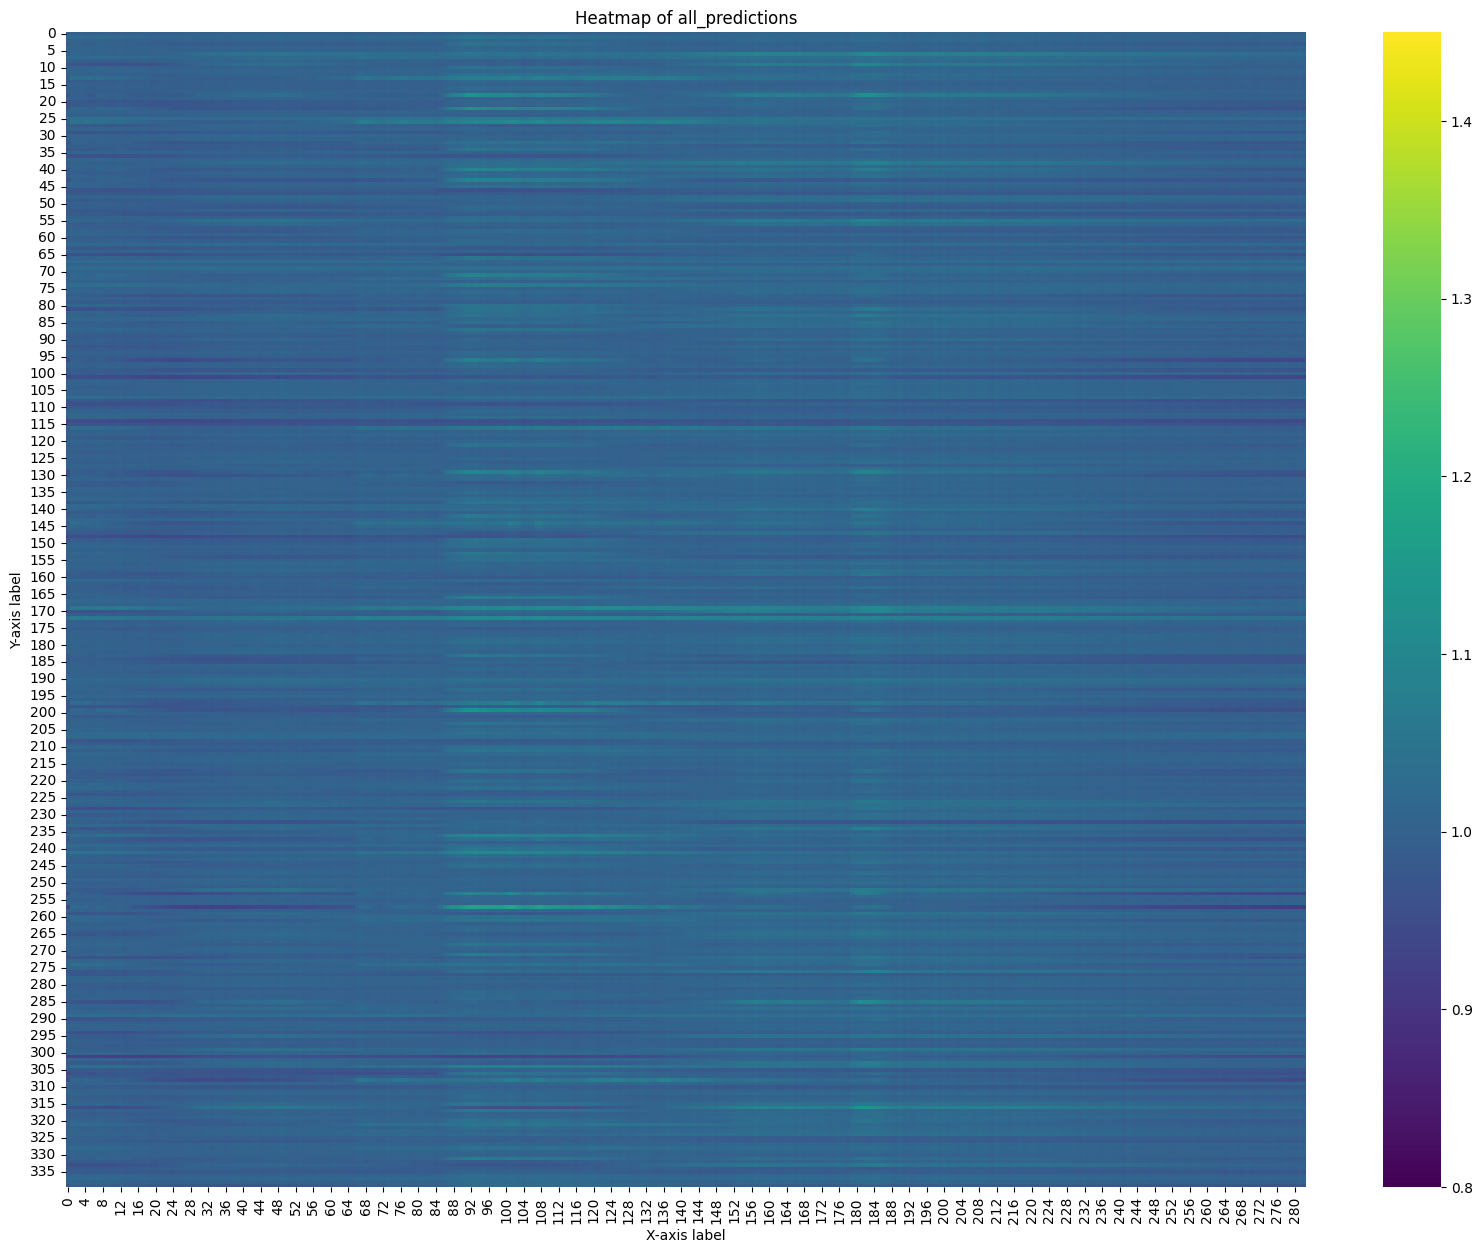

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [14]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv('input/ariel-data-challenge-2024/wavelengths.csv')
train_adc_info = pd.read_csv(
    'input/ariel-data-challenge-2024/train_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv('input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')

In [15]:
targets = full_targets_normalized * (target_max - target_min) + target_min
reviewtarget = targets[mask]

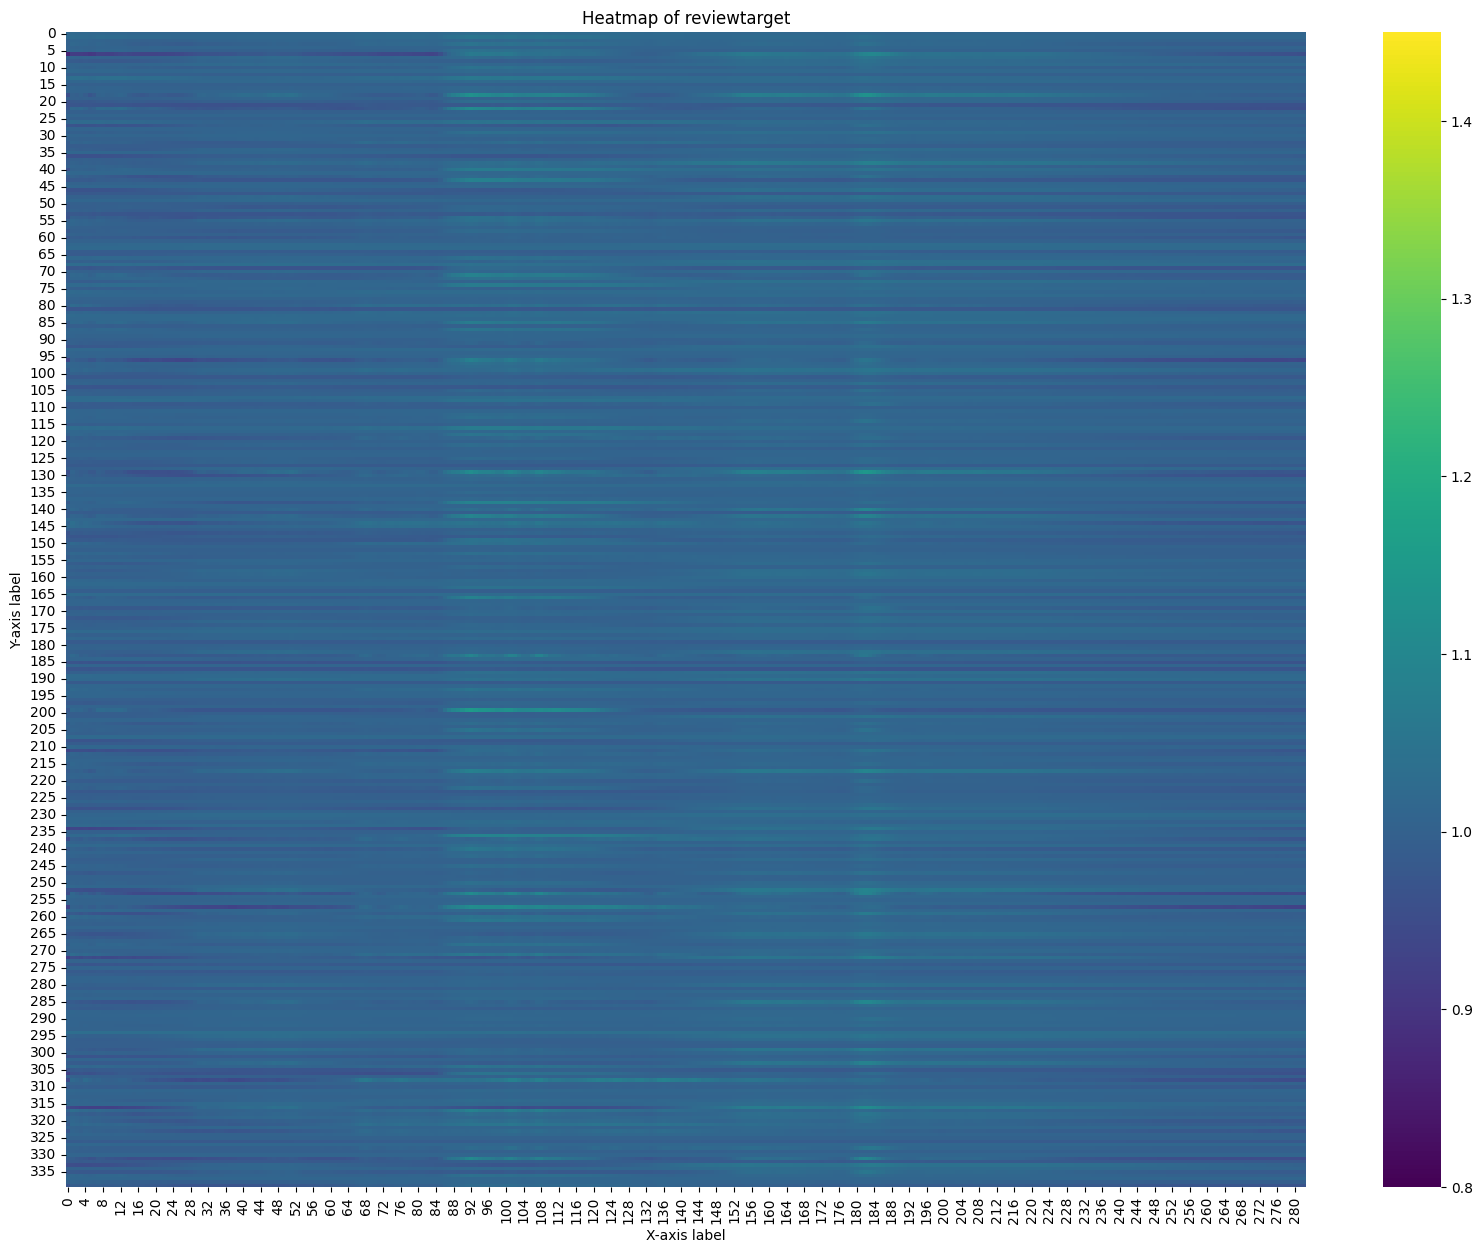

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [17]:
reviewtarget = reviewtarget.numpy()
reviewtarget.min(), reviewtarget.max()

(0.8628884, 1.1572386)

In [18]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]

In [19]:
reviewtarget = reviewtarget * whitelight_s_test[:, np.newaxis]

In [20]:
print(f"# R2 score: {r2_score(reviewtarget, all_predictions):.6f}")
sigma_pred = mean_squared_error(reviewtarget, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.999553
# Root mean squared error: 0.000037


In [21]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        train_adc_info[mask].index,
                        sigma_pred=np.tile(
                            np.where(train_adc_info[mask][['star']] <= 1,
                                     sigma_pred, sigma_pred), (1, 283)))

In [22]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.6}")

# Estimated competition score: 0.683671


In [23]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - reviewtarget[:, col])
    outliers = np.where(errors > sigma_pred * threshold)[0]
    normals = np.where(errors <= sigma_pred * threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 187 is an outlier in 283 columns and normal in columns: []
Data point 217 is an outlier in 200 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 95, 98, 99, 101, 102, 103, 106, 107, 108, 109, 110, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
Data point 176 is an outlier in 176 columns and normal in columns: [1, 2, 3, 5, 7, 8, 12, 32, 43, 49, 57, 61, 67, 73, 81, 82, 87, 88, 90, 91, 92, 93, 94, 95, 98, 99, 101, 102, 103, 107, 108, 109, 110, 111, 113, 114, 118, 119, 120, 122, 123, 125, 126, 127, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 143, 147, 149, 153, 157, 158, 159, 160, 164, 165, 167, 172, 175, 176, 177, 179, 180, 181, 182, 184, 185, 186, 187, 190, 192, 194, 195, 196, 198, 199, 200, 201, 202, 204, 205, 208, 209, 212, 214, 216, 217, 2

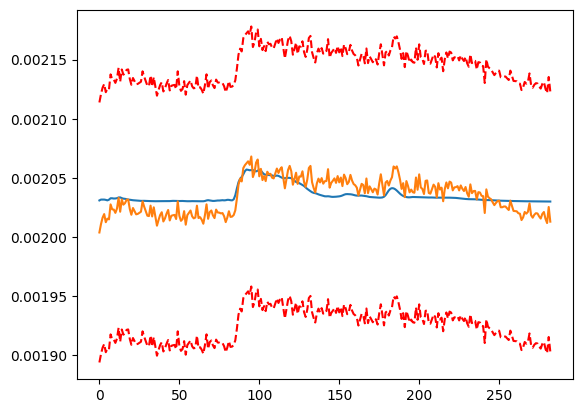

In [24]:
planet = 283
plt.plot(reviewtarget[planet, :])
plt.plot(all_predictions[planet, :])
plt.plot(all_predictions[planet, :] + 3 * sigma_pred, 'r--')
plt.plot(all_predictions[planet, :] - 3 * sigma_pred, 'r--')